# Predicting Whether or Not a MineCraft Player is Subscribed to a Gaming Newsletter #

**Group 9: Lilien B, Colin K, Lara M, Palmer W**
  

# Introduction: #

Player engagement in video games is a valuable metric as game developers seek to foster a wider community to create a more enjoyable player experience. One way to maintain player engagement is to subscribe to gaming newsletters as it continually updates players on new information and updates that come to the game. Thus, it would be helpful to see what factors contribute to players being subscribed to a newsletter. However, it can be a challenge to predict what player behaviours will lead to maximum player engagement, such as a subscription to a newsletter. By building a classification model, it will allow developers to use game statistics to see and predict if the player is subscribed to the newsletter.

Classification is the practice of categorizing things based on previous observations or variables. This is useful in data science as it allows us to predict and characterize observations without a known class. By building a classification model, we try to predict if a player is subscribed to the newsletter based on other variables. To build a model to perform the classification, we used a data set collected by researchers at UBC about play sessions of participants in a Minecraft server. With this dataset we plan to answer the question: Can played hours and age predict whether a player is subscribed to a gaming newsletter? The dataset contains player information including experience, if they are subscribed to the newsletter, a hashed email, played hours, name, gender, and age. From these variables, we will use played hours, age and if they are subscribed to the newsletter to train a classifier model.


# Method: #

Firstly, we will load the tidyverse and tidymodels packages to provide the functions we will use for this project. Next, let's load the players dataset using the read_csv function. Additionally, we will use the drop_na() function to get rid of rows containing N/A values. 

In [1]:
library(tidyverse)
library(tidymodels)

tidy_players <- read_csv("https://raw.githubusercontent.com/pwelters/dsci_project_data/refs/heads/main/players.csv") |>
    drop_na()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

The dataset is now loaded and we can visualize relationship between, played hours, age and whether the player is subscirbe to the newsletter. In order for the code to be reproducible, we will use set.seed to ensure all random processes are the same no matter who runs the code. This will be continued throughout the analysis. To visualize the data, we will use ggplot2 package, but first we need to change the subscibe variable from a character value to a factor. After, we will plot the data with age on the x axis and hours played on the y axis with the color of the data points being colored based on is the player is subscribed.

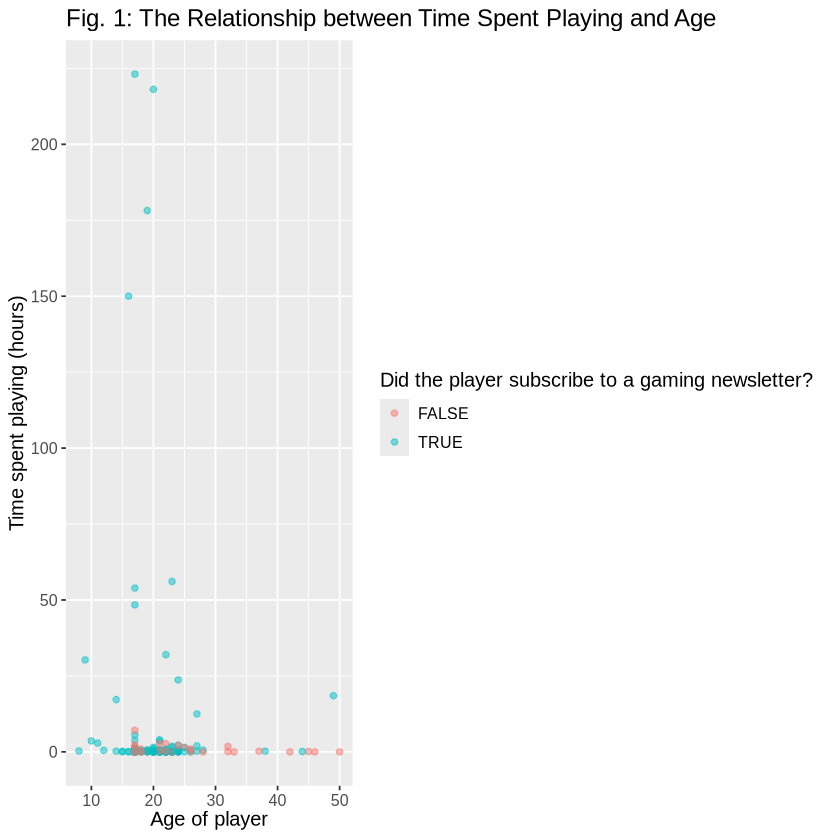

In [11]:
# set the seed
set.seed(1)

# load data
tidy_players <- tidy_players |>
    mutate(subscribe = as_factor(subscribe))

# create scatter plot of age versus played hours,
# labeling the points be subscribe class

time_age_plot <- tidy_players |>
    ggplot(aes( x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5) +
    labs( x = "Age of player", y = "Time spent playing (hours)", color = "Did the player subscribe to a gaming newsletter?") +
    ggtitle("Fig. 1: The Relationship between Time Spent Playing and Age") +
    theme(text = element_text(size = 12))

time_age_plot

In [3]:
# Ratio of subscribed and unsubscribed players to ensure that the proportion is maintained when splitting into training and testing groups
og_proportions <- tidy_players |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(tidy_players))

og_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


In [4]:
set.seed(2)
#splitting data into training and testing groups, maintaining original proportions

subscribe_split <- initial_split(tidy_players, prop = 0.75, strata = subscribe)
subscribe_train <- training(subscribe_split)
subscribe_test <- testing(subscribe_split)

subscribe_train_proportions <- subscribe_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(subscribe_train))

subscribe_test_proportions <- subscribe_test |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(subscribe_test))

subscribe_train_proportions
subscribe_test_proportions

#we can confirm that the proportions are preserved

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,13,26.53061
TRUE,36,73.46939


In [5]:
#recipe
subscribe_recipe <- recipe(subscribe ~ Age + played_hours, data = subscribe_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


 knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
     set_engine("kknn") |>
     set_mode("classification")

 knn_fit <- workflow() |>
     add_recipe(subscribe_recipe) |>
     add_model(knn_spec) |>
     fit(data = subscribe_train)

 knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3931034
Best kernel: rectangular
Best k: 5

In [21]:
set.seed(3)
subscribe_vfold <- vfold_cv(subscribe_train, v = 5, strata = subscribe)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn")|>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

tune_fit <- workflow() |>
add_recipe(subscribe_recipe) |>
add_model(knn_tune)|>
tune_grid(resamples = subscribe_vfold, grid = k_vals) |>
collect_metrics()

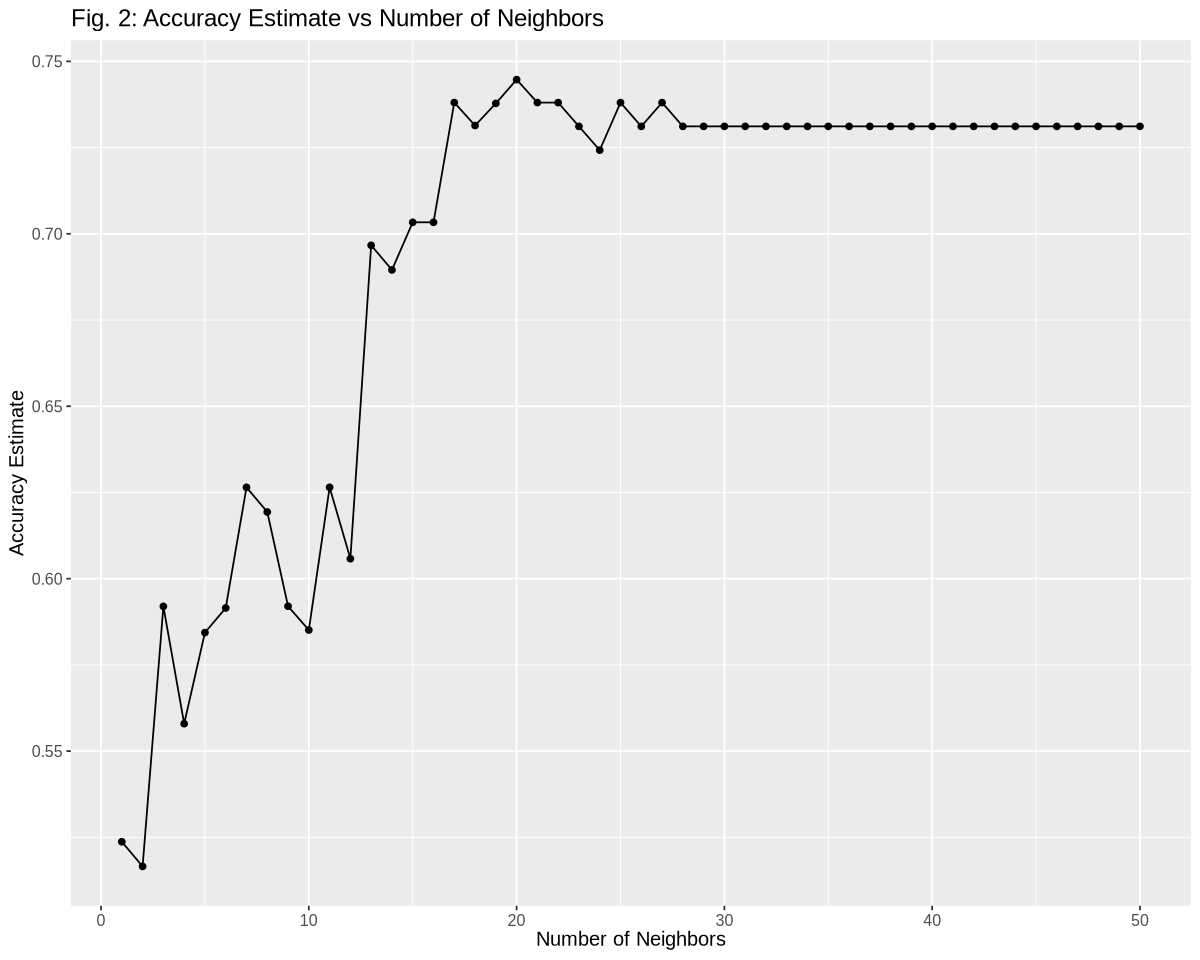

In [23]:
set.seed(5)
accurate_k <- tune_fit |>
filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 8)
k_accuracy_plot <- ggplot(accurate_k, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors", y = "Accuracy Estimate") +
    ggtitle("Fig. 2: Accuracy Estimate vs Number of Neighbors")+
  theme(text = element_text(size = 12))

k_accuracy_plot

In [18]:
best_k_value <- accurate_k |>
arrange(desc(mean)) |>
head(1) |>
pull(neighbors)

best_k_value

[1] 20

In [19]:
set.seed(5)
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) |>
set_engine("kknn")|>
set_mode("classification")

final_knn_fit <- workflow() |>
add_recipe(subscribe_recipe)|>
add_model(best_knn_spec)|>
fit(data = subscribe_train)

In [20]:
subscribe_test_predictions <- predict(final_knn_fit, subscribe_test) |>
bind_cols(subscribe_test)|>
metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")

subscribe_test_predictions




.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


# Discussion: #